# E-commerce Learn-to-rank RAG with Elasticsearch

<div style="text-align: right"> Created by Craig Angulo </div>


In this jupyter notebook we will build a learn-to-rank model that is trained on ecommerce data, this model will be used to provide a RAG application with more accurate product suggestions for improved customer interactions.
 
First, we will create an index in elasticstore. Then load the data into the newly created index. Once the data is uploaded to elasticsearch a feature extraction will be ran to get BM25 ratings of relevant data columns. An ensemble algorithm will be trained on the extracted features and then loaded into elasticsearch as a learn-to-rank model. Using the new learn-to-rank model a query will be submitted, the results will be rank, then the results are fed into a RAG application to generate a response. 


In [579]:
%pip install python-dotenv eland elasticsearch pandas numpy scikit-learn sentence-transformers torch xgboost

Package                                 Version
--------------------------------------- --------------
accelerate                              1.1.1
ace_tools                               0.0
aiohappyeyeballs                        2.4.3
aiohttp                                 3.10.10
aiosignal                               1.3.1
annotated-types                         0.7.0
anyio                                   4.6.2.post1
appnope                                 0.1.4
argon2-cffi                             23.1.0
argon2-cffi-bindings                    21.2.0
arrow                                   1.3.0
asttokens                               2.4.1
async-lru                               2.0.4
attrs                                   24.2.0
babel                                   2.16.0
beautifulsoup4                          4.12.3
bleach                                  6.2.0
certifi                                 2024.8.30
cffi                                    1.17.1
charset

## Connect to Elasticsearch
We will begin by implementing our data elasticsearch client and then we will import our data, I currently have it saved locally but you can retrieve the data here: https://github.com/amazon-science/esci-data

In [10]:
from elasticsearch import Elasticsearch
from dotenv import load_dotenv
import os

# Connect to your Elasticsearch instance
load_dotenv('.env')
CLOUD_ID=os.getenv("ELASTIC_CLOUD_ID")
API_KEY=os.getenv("ELASTIC_API_KEY")

es_client = Elasticsearch(
  cloud_id = CLOUD_ID,
  api_key= API_KEY
)

# Test connection to Elasticsearch
print(es_client.info())

Python-dotenv could not parse statement starting at line 1


{'name': 'serverless', 'cluster_name': 'd668de5dd3e747f588cf0949aea1f1ac', 'cluster_uuid': 'ckx4sUZ-TtyoWGwTgnT21Q', 'version': {'number': '8.11.0', 'build_flavor': 'serverless', 'build_type': 'docker', 'build_hash': '00000000', 'build_date': '2023-10-31', 'build_snapshot': False, 'lucene_version': '9.7.0', 'minimum_wire_compatibility_version': '8.11.0', 'minimum_index_compatibility_version': '8.11.0'}, 'tagline': 'You Know, for Search'}


In [2]:
import pandas as pd
df_examples = pd.read_parquet('~/shopping_queries_dataset_examples.parquet')
df_products = pd.read_parquet('~/shopping_queries_dataset_products.parquet')

Below we can see our two dataframes df_examples and df_products. 

df_examples contains information that we will be using for our learn-to-rank training, this dataset comes with ESCI_labels () which allow us to categories the relevance our search queries in regards to each product.

df_products includes product details like title, desription, and brand

In [1]:
df_examples.head()

NameError: name 'df_examples' is not defined

In [533]:
df_products.head()

,product_id,product_title,product_description,product_bullet_point,product_brand,product_color,product_locale
0,B079VKKJN7,"11 Degrees de los Hombres Playera con Logo, Ne...",Esta playera con el logo de la marca Carrier d...,11 Degrees Negro Playera con logo\nA estrenar ...,11 Degrees,Negro,es
1,B079Y9VRKS,Camiseta Eleven Degrees Core TS White (M),None,None,11 Degrees,Blanco,es
2,B07DP4LM9H,11 Degrees de los Hombres Core Pull Over Hoodi...,La sudadera con capucha Core Pull Over de 11 G...,11 Degrees Azul Core Pull Over Hoodie\nA estre...,11 Degrees,Azul,es
3,B07G37B9HP,11 Degrees Poli Panel Track Pant XL Black,None,None,11 Degrees,None,es
4,B07LCTGDHY,11 Degrees Gorra Trucker Negro OSFA (Talla úni...,None,None,11 Degrees,Negro (,es


In [3]:
df_merged = pd.merge(
    df_examples,
    df_products,
    how='left',
    left_on=['product_locale','product_id'],
    right_on=['product_locale', 'product_id']
)

In this notebook I will only be building an english language model so I will be filtering my dataset on locale. Then I will split my data

In [4]:
df_task_1 = df_merged[(df_merged["small_version"] == 1) & (df_merged["product_locale"] == 'us')]

In [13]:
df_task_1.head()

,example_id,query,query_id,product_id,product_locale,esci_label,small_version,large_version,split,product_title,product_description,product_bullet_point,product_brand,product_color
16,16,!awnmower tires without rims,1,B075SCHMPY,us,I,1,1,train,"RamPro 10"" All Purpose Utility Air Tires/Wheel...","<b>About The Ram-Pro All Purpose Utility 10"" A...",✓ The Ram-Pro Ten Inch ready to install Air Ti...,RamPro,10 Inch
17,17,!awnmower tires without rims,1,B08L3B9B9P,us,E,1,1,train,MaxAuto 2-Pack 13x5.00-6 2PLY Turf Mower Tract...,MaxAuto 2-Pack 13x5.00-6 2PLY Turf Mower Tract...,Please check your existing tire Sidewall for t...,MaxAuto,None
18,18,!awnmower tires without rims,1,B082K7V2GZ,us,I,1,1,train,NEIKO 20601A 14.5 inch Steel Tire Spoon Lever ...,None,[QUALITY]: Hardened Steel-Iron construction wi...,Neiko,None
19,19,!awnmower tires without rims,1,B07P4CF3DP,us,S,1,1,train,2PK 13x5.00-6 13x5.00x6 13x5x6 13x5-6 2PLY Tur...,"Tire Size: 13 x 5.00 - 6 Axle: 3/4"" inside dia...",None,Russo,None
20,20,!awnmower tires without rims,1,B07C1WZG12,us,E,1,1,train,(Set of 2) 15x6.00-6 Husqvarna/Poulan Tire Whe...,No fuss. Just take off your old assembly and r...,Tire size:15x6.00-6 Ply: 4 Tubeless\n6x4.5 Whe...,Antego Tire & Wheel,Husqvarna Silver


## Create a new index in elasticsearch
index all of the product data into ES

In [577]:
from elasticsearch import Elasticsearch, helpers 


# Initialize Elasticsearch client
es = es_client

# Define index name
index_name = "product_index"

# Step 1: Delete the existing index if needed (Optional)
if es.indices.exists(index=index_name):
    es.indices.delete(index=index_name)
    print(f"Deleted existing index: {index_name}")

# Step 2: Create the new index with a mapping
mapping = {
    "mappings": {
        "properties": {
            "example_id": {"type": "integer"},
            "query": {"type": "text"},
            "query_id": {"type": "integer"},
            "product_id": {"type": "keyword"},
            "product_locale": {"type": "keyword"},
            "esci_label": {"type": "keyword"},
            "small_version": {"type": "integer"},
            "large_version": {"type": "integer"},
            "split": {"type": "keyword"},
            "product_title": {"type": "text"},
            "product_description": {"type": "text"},
            "product_bullet_point": {"type": "text"}
        }
    }
}
# Create the index with the defined mapping
es.indices.create(index=index_name, body=mapping)
print(f"Created new index: {index_name}")

Created new index: vector_test_product_index


## Define your ltr_config so that you extract the correct features with your feature_logger

In [238]:
from eland.ml.ltr import LTRModelConfig, QueryFeatureExtractor

# Define the LTR model configuration using BM25 features
ltr_config = LTRModelConfig(
    feature_extractors=[
        # BM25 scores for text fields
        QueryFeatureExtractor(
            feature_name="title_bm25",
            query={"match": {"product_title": "{{query}}"}}
        ),
        QueryFeatureExtractor(
            feature_name="description_bm25",
            query={"match": {"product_description": "{{query}}"}}
        ),
        QueryFeatureExtractor(
            feature_name="bullet_point_bm25",
            query={"match": {"product_bullet_point": "{{query}}"}}
        )
    ]
)


Batch you data for easier processing and then submit your ltr_config with feature_logger. The feature logger will then match on the _ID of your index with the product_id and extract the BM25 features.

In [479]:
def generate_data(df):
    data_list = []
    for _, row in df.iterrows(): 
        data_list.append({
            "_index": index_name,
            "_id": row["product_id"],  # Set the `_id` to be the `product_id`
            "_source": {
                "example_id": row["example_id"],
                "query": row["query"],
                "query_id": row["query_id"],
                "product_id": row["product_id"],
                "product_locale": row["product_locale"],
                "esci_label": row["esci_label"],
                "small_version": row["small_version"],
                "large_version": row["large_version"],
                "split": row["split"],
                "product_title": row["product_title"],
                "product_description": row["product_description"],
                "product_bullet_point": row["product_bullet_point"]
            }
        })
    return data_list


def batch_index_data(df, batch_size=100):
    total_rows = len(df)
    for start in range(0, total_rows, batch_size):
        end = min(start + batch_size, total_rows)
        batch_df = df.iloc[start:end]
        index_batch(batch_df)

  
def index_batch(batch_df):
    try:
        helpers.bulk(es, batch_df)
        print(f"Successfully indexed batch of size {len(batch_df)}.")
    except Exception as e:
        print(f"Error indexing batch: {e}")

# Use the batch_index_data function to index the data in batches of 100
batch_index_data(df_task_1, batch_size=2500)
print(f"Successfully indexed the data into {index_name}.")

        example_id                         query  query_id  product_id  \
0               16  !awnmower tires without rims         1  B075SCHMPY   
1               17  !awnmower tires without rims         1  B08L3B9B9P   
2               18  !awnmower tires without rims         1  B082K7V2GZ   
3               19  !awnmower tires without rims         1  B07P4CF3DP   
4               20  !awnmower tires without rims         1  B07C1WZG12   
...            ...                           ...       ...         ...   
601349     2618565                       자전거트레일러    130539  B06XTZYJL3   
601350     2618566                       자전거트레일러    130539  B010LLGWL8   
601351     2618567                       자전거트레일러    130539  B010LLGWKE   
601352     2618568                       자전거트레일러    130539  B003CUBPUY   
601353     2618569                       자전거트레일러    130539  B002KV1MJU   

       product_locale esci_label  small_version  large_version  split  \
0                  us          I      

Clean up our results by replacing null values with 0's and assinging numerical values to our ESCI labels. 

In [483]:
# Replace NaN values in bm25 columns with 0
bm25_columns = ['title_bm25', 'description_bm25', 'bullet_point_bm25']
feature_df[bm25_columns] = feature_df[bm25_columns].fillna(0)

# Map esci_label column
esci_mapping = {'E': 4, 'S': 3, 'C': 2, 'I': 1}
feature_df['esci_label'] = feature_df['esci_label'].map(esci_mapping)

# Print the DataFrame to verify the results
feature_df.head()


,example_id,query,query_id,product_id,product_locale,esci_label,small_version,large_version,split,product_title,product_description,product_bullet_point,product_brand,product_color,title_bm25,description_bm25,bullet_point_bm25
0,16,!awnmower tires without rims,1,B075SCHMPY,us,1,1,1,train,"RamPro 10"" All Purpose Utility Air Tires/Wheel...","<b>About The Ram-Pro All Purpose Utility 10"" A...",✓ The Ram-Pro Ten Inch ready to install Air Ti...,RamPro,10 Inch,6.610261,9.715838,8.548265
1,17,!awnmower tires without rims,1,B08L3B9B9P,us,4,1,1,train,MaxAuto 2-Pack 13x5.00-6 2PLY Turf Mower Tract...,MaxAuto 2-Pack 13x5.00-6 2PLY Turf Mower Tract...,Please check your existing tire Sidewall for t...,MaxAuto,None,0.000000,0.000000,6.241272
2,18,!awnmower tires without rims,1,B082K7V2GZ,us,1,1,1,train,NEIKO 20601A 14.5 inch Steel Tire Spoon Lever ...,None,[QUALITY]: Hardened Steel-Iron construction wi...,Neiko,None,0.000000,0.000000,14.155165
3,19,!awnmower tires without rims,1,B07P4CF3DP,us,3,1,1,train,2PK 13x5.00-6 13x5.00x6 13x5x6 13x5-6 2PLY Tur...,"Tire Size: 13 x 5.00 - 6 Axle: 3/4"" inside dia...",None,Russo,None,0.000000,0.000000,0.000000
4,20,!awnmower tires without rims,1,B07C1WZG12,us,4,1,1,train,(Set of 2) 15x6.00-6 Husqvarna/Poulan Tire Whe...,No fuss. Just take off your old assembly and r...,Tire size:15x6.00-6 Ply: 4 Tubeless\n6x4.5 Whe...,Antego Tire & Wheel,Husqvarna Silver,0.000000,0.000000,0.000000


In [484]:
df_task_1_train = feature_df[feature_df["split"] == "train"]
df_task_1_test = feature_df[feature_df["split"] == "test"]

feature_columns = ltr_config.feature_names
train_X = df_task_1_train[bm25_columns]
train_y = df_task_1_train["esci_label"]
train_group = df_task_1_train.groupby("query_id").size().to_list()

test_X = df_task_1_test[bm25_columns]
test_y = df_task_1_test["esci_label"]
test_group = df_task_1_test.groupby("query_id").size().to_list()

## Train your LTR model with ensembling 

In [505]:
# Initialize the XGBRanker with tuned parameters
ranker = XGBRanker(
    objective="rank:ndcg",
    eval_metric=["ndcg@20"],
    learning_rate=0.1,  # Smaller learning rate
    n_estimators=300,  # Increase boosting rounds
    max_depth=3,  # Experiment with different values
    min_child_weight=5,
    early_stopping_rounds=10,
    enable_categorical=True
)

# Train the model
ranker.fit(
    train_X,
    train_y,
    group=train_group,
    eval_set=[(test_X, test_y)],
    eval_group=[test_group],
    verbose=True
)

# Print model details
to_print = ranker.get_booster().get_dump()

[0]	validation_0-ndcg@20:0.86664
[1]	validation_0-ndcg@20:0.86778
[2]	validation_0-ndcg@20:0.86936
[3]	validation_0-ndcg@20:0.86971
[4]	validation_0-ndcg@20:0.87033
[5]	validation_0-ndcg@20:0.87053
[6]	validation_0-ndcg@20:0.87072
[7]	validation_0-ndcg@20:0.87057
[8]	validation_0-ndcg@20:0.87078
[9]	validation_0-ndcg@20:0.87061
[10]	validation_0-ndcg@20:0.87063
[11]	validation_0-ndcg@20:0.87078
[12]	validation_0-ndcg@20:0.87079
[13]	validation_0-ndcg@20:0.87096
[14]	validation_0-ndcg@20:0.87102
[15]	validation_0-ndcg@20:0.87110
[16]	validation_0-ndcg@20:0.87134
[17]	validation_0-ndcg@20:0.87147
[18]	validation_0-ndcg@20:0.87145
[19]	validation_0-ndcg@20:0.87153
[20]	validation_0-ndcg@20:0.87152
[21]	validation_0-ndcg@20:0.87150
[22]	validation_0-ndcg@20:0.87158
[23]	validation_0-ndcg@20:0.87157
[24]	validation_0-ndcg@20:0.87159
[25]	validation_0-ndcg@20:0.87165
[26]	validation_0-ndcg@20:0.87175
[27]	validation_0-ndcg@20:0.87180
[28]	validation_0-ndcg@20:0.87188
[29]	validation_0-ndcg@2

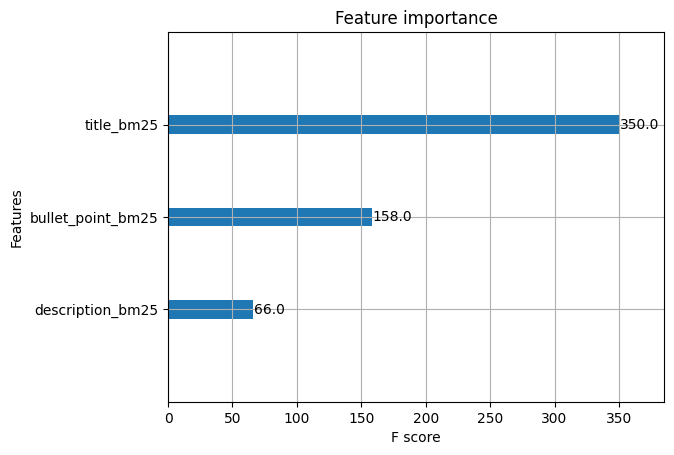

In [580]:
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(ranker, max_num_features=10)
plt.show()


In [506]:
ranker.save_model("ltr_model.json")

## Import your model into elasticsearch

In [509]:
from eland.ml import MLModel
# Define feature names that match the features used in training the XGBRanker model
feature_names = ltr_config.feature_names  # Assuming you have a list of feature names in your LTR configuration

# Import the model into Elasticsearch
MLModel.import_ltr_model(
    es_client=es,
    model = ranker,
    model_id="ltr_model",
    ltr_model_config=ltr_config,
    es_if_exists="replace",
)


## Query testing
Using elasticsearch's BM25 query we can perform a similarity search and return documents

In [526]:
# Test case to validate the model with a given query
query = "star wars toy"

# First, display the result when not using the rescorer:
search_fields = ["product_title", "product_description", "product_bullet_point", "product_brand", "product_color"]
bm25_query = {"multi_match": {"query": query, "fields": search_fields}}

bm25_search_response = es_client.search(index="product_index", query=bm25_query)

bm25_results = [
    (product["_source"]["product_title"], product["_score"], product["_id"])
    for product in bm25_search_response["hits"]["hits"]
]

print("BM25 Search Results:")
for title, score, product_id in bm25_results:
    print(f"Title: {title}, Score: {score}, Product ID: {product_id}")


BM25 Search Results:
Title: LEGO Star Wars Resistance Black Ace TIE Interceptor 75242 Building Kit (396 Pieces), Score: 26.241209, Product ID: B07JNCD33K
Title: LEGO Star Wars Boy's Flannel Pajama Pants (6-7, Black/Red), Score: 25.49963, Product ID: B079RN2V6R
Title: Star Wars Droids #1 VF 8.0 White Pgs Star R2D2 C3PO Marvel Comics, Score: 25.193813, Product ID: B088JL3YYC
Title: Star Wars The Black Series Snowspeeder Vehicle with Dak Ralter Figure 6-Inch-Scale The Empire Strikes Back Collectible Toys, Score: 25.018623, Product ID: B0824RKNY2
Title: LEGO Star Wars: A New Hope 75244 Tantive IV Building Kit (1768 Pieces), Score: 24.727962, Product ID: B07NDYHY8S
Title: LEGO Star Wars: A New Hope Luke Skywalker's Landspeeder 75271 Building Kit, Collectible Star Wars Set (236 Pieces), Score: 24.715897, Product ID: B07WHMBVT9
Title: Lego Star Wars Darth Vader 13" Plush Character, Score: 24.57547, Product ID: B086W357DS
Title: Lego Star Wars Chewbacca 13" Plush Character, Score: 24.57547, Pr

## Query Search with Learn-to-rank

In [590]:
import pprint
# Query the product index with rescoring using LTR

ltr_rescorer = {
    "learning_to_rank": {
        "model_id": "ltr_model",  # Replace with your LTR model ID
        "params": {"query": query},
    },
    "window_size": 100,
}

rescored_search_response = es.search(
    index="product_index", query=bm25_query, rescore=ltr_rescorer
)

# Extract the top rescored documents
rescored_documents = [
    {
        "product_id": hit["_id"],
        "score": hit["_score"],
        "product_title": hit["_source"]["product_title"],
        "product_description": hit["_source"]["product_description"]
    }
    for hit in rescored_search_response["hits"]["hits"]
]
 
    
print(f"Rescored documents: {rescored_documents}")

Rescored documents: [{'product_id': 'B015RTJJKU', 'score': 1.2196535, 'product_title': 'Star Wars Star Wars E2 Jango Fett Toy', 'product_description': None}, {'product_id': 'B01AW1R5TU', 'score': 1.1631908, 'product_title': 'LEGO STAR WARS Carbon-Freezing Chamber 75137 Star Wars Toy', 'product_description': None}, {'product_id': 'B01CIGN2TE', 'score': 1.1631908, 'product_title': 'LEGO STAR WARS Clone Turbo Tank 75151 Star Wars Toy', 'product_description': None}, {'product_id': 'B00NHQI2DG', 'score': 1.1559619, 'product_title': 'LEGO Star Wars 75080 AAT Toy', 'product_description': None}, {'product_id': 'B01E78WLF2', 'score': 1.113077, 'product_title': 'LEGO Star Wars First Order Special Forces TIE Fighter 75101 Star Wars Toy', 'product_description': None}, {'product_id': 'B0792RDN2T', 'score': 1.0993867, 'product_title': '75213 LEGO Star Wars Star Wars Advent Calendar', 'product_description': "Open the doors of this galactic LEGO star wars kids toy advent calendar each day in December 

## Generate a response with your LLM

In [576]:
# Define the LLM endpoint
llm_endpoint = "http://localhost:1234/v1/completions"

# Construct the prompt to generate a customer-facing response based on top 5 rescored documents
combined_info = "\n\n".join([
    f"Product {idx + 1}:\nTitle: {doc['product_title']}\nDescription: {doc['product_description']}"
    for idx, doc in enumerate(rescored_documents)
])

prompt = (
    f"Based on the following top 5 products for the query '{query}', generate a product recommendation for a customer:\n"
    f"{combined_info}\n"
    "Recommendation:"
)
# Prepare payload for LLM studio
payload = {
    "model": "llama-3.2-3b-instruct",  # Replace with your model name
    "prompt": prompt,
    "max_tokens": 200,
    "temperature": 0.7,
    "n": 1,
    "stop": ["Recommendation:"]
}

# Make a POST request to LLM studio
try:
    response = requests.post(llm_endpoint, json=payload)

    # Check response from LLM model
    if response.status_code == 200:
        llm_response = response.json()
        print(f"LLM Response: {llm_response}")
    else:
        print(f"Failed to generate recommendation: {response.status_code} {response.text}")

except requests.exceptions.RequestException as e:
    print(f"Error sending request to LLM endpoint: {e}")


LLM Response: {'id': 'cmpl-f6ii10lgcqfdl7k00lft7n', 'object': 'text_completion', 'created': 1732149219, 'model': 'llama-3.2-3b-instruct', 'choices': [{'index': 0, 'text': " Based on the top 5 products for the query 'tar wars toy', I would recommend the LEGO Star Wars First Order Special Forces TIE Fighter 75101 Star Wars Toy.\n\nReason for recommendation: This product stands out from the other toys in the top 5 list because of its high-quality and unique design. The TIE Fighter is a popular character in the Star Wars universe, and its special forces variant makes it an exciting addition to any collection. Additionally, the product includes 3 figures, which is a great bonus for fans of all ages.\n\nWhile Boba Fett's toy figure is also an excellent choice, the LEGO Star Wars First Order Special Forces TIE Fighter 75101 has a few more features that make it a better fit for the customer. The included minifigures, spring-loaded blaster shooters, and desert camouflage elements make it a more